In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from kitti_object import kitti_object, show_lidar_with_depth, show_lidar_on_image, \
                         show_image_with_boxes, show_lidar_topview_with_boxes


In [4]:
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()
from mayavi import mlab
mlab.init_notebook('ipy') # do not use 'x3d' backend which leads to color missing

/root/miniconda3/envs/kitti_vis/lib/python3.7/site-packages/traits/etsconfig/etsconfig.py:415: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  % (environment_variable, parent_directory)


Notebook initialized with ipy backend.


In [44]:
objects

In [49]:
# dataset = kitti_object('../data/object', 'training')
dataset = kitti_object('../models/mmdetection3d/data/kitti/', 'training')

data_idx = 1
objects = dataset.get_label_objects(data_idx)
objects = dataset.get_pred_objects(data_idx)
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

fig_3d = mlab.figure(bgcolor=(0, 0, 0), size=(800, 450))
show_lidar_with_depth(pc_velo, objects, calib, fig_3d, True, img_width, img_height)
fig_3d

../models/mmdetection3d/data/kitti/ training
11
../models/mmdetection3d/data/kitti/training/velodyne/000001.bin
('All point num: ', 308525)
('FOV point num: ', (308310, 4))
pc_velo (308310, 4)
==================== (308310, 4)
box3d_pts_3d_velo:
[[40.41840497 22.486899   -0.61733818]
 [39.74740649 24.20562663 -0.60618952]
 [40.40365042 24.46176492 -0.59662491]
 [41.07464891 22.74303729 -0.60777357]
 [40.40049168 22.46878694  1.09676085]
 [39.72949319 24.18751457  1.10790952]
 [40.38573713 24.44365286  1.11747412]
 [41.05673561 22.72492522  1.10632546]]
box3d_pts_3d_velo:
[[40.41840497 22.486899   -0.61733818]
 [39.74740649 24.20562663 -0.60618952]
 [40.40365042 24.46176492 -0.59662491]
 [41.07464891 22.74303729 -0.60777357]
 [40.40049168 22.46878694  1.09676085]
 [39.72949319 24.18751457  1.10790952]
 [40.38573713 24.44365286  1.11747412]
 [41.05673561 22.72492522  1.10632546]]
box3d_pts_3d_velo:
[[53.60481094 19.48982717 -0.76369719]
 [53.22628935 20.96632255 -0.75205153]
 [54.7729013 

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x01\xc2\x08\x02\x00\x00\x00\x98\x01:\x9…

In [39]:
img_lidar = show_lidar_on_image(pc_velo[:, :3], img, calib, img_width, img_height)
img_lidar = cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB)

fig_lidar = plt.figure(figsize=(14, 7))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.show()

IndexError: index 300 is out of bounds for axis 0 with size 256

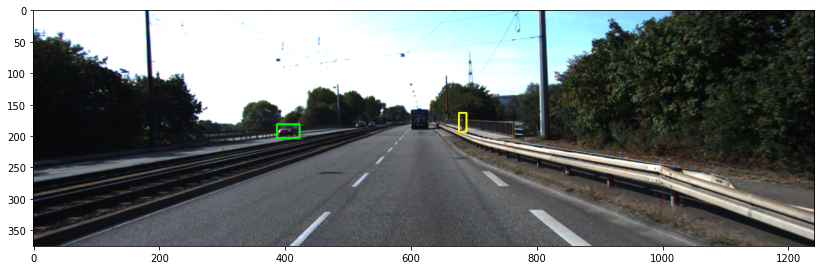

In [40]:
img_bbox2d, img_bbox3d = show_image_with_boxes(img, objects, calib)
img_bbox2d = cv2.cvtColor(img_bbox2d, cv2.COLOR_BGR2RGB)

fig_bbox2d = plt.figure(figsize=(14, 7))
ax_bbox2d = fig_bbox2d.subplots()
ax_bbox2d.imshow(img_bbox2d)
plt.show()

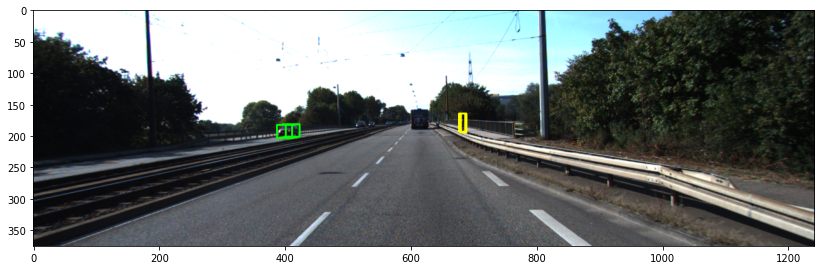

In [41]:
img_bbox3d = cv2.cvtColor(img_bbox3d, cv2.COLOR_BGR2RGB)

fig_bbox3d = plt.figure(figsize=(14, 7))
ax_bbox3d = fig_bbox3d.subplots()
ax_bbox3d.imshow(img_bbox3d)
plt.show()

top_image: (500, 300, 3)


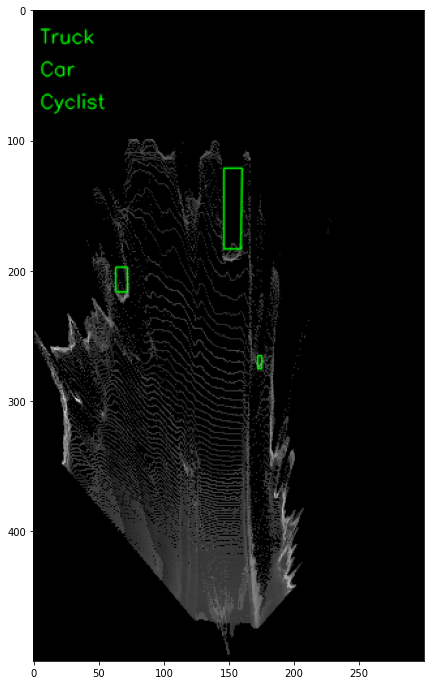

In [42]:
img_bev = show_lidar_topview_with_boxes(pc_velo, objects, calib)

fig_bev = plt.figure(figsize=(7, 14))
ax_bev = fig_bev.subplots()
ax_bev.imshow(img_bev)
plt.show()